# Ionisation potential of a bulk material

In this example we use `MacroDensity` with `VASP` to align the energy levels of a simple bulk material.

The procedure involves two DFT calculations, yielding different quantities:

* **A bulk calculation**, this provides us with the VBM eigenvalue under the assumption of zero potential ($\epsilon_{vbm}$)
* **A slab calculation**, this provides us with the vacuum level with resepct to the potential inside the material, the difference between these values is the surface dipole ($D_s$).

The ionisation potential ($IP$) is then obtained from:

$IP = D_s - \epsilon_{vbm}$

In [2]:
%matplotlib inline
import sys
import macrodensity as md
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

## Bulk calculation

First, we calculate the eigenvalues of the bulk material, under the assumption of zero average potential.

In `VASP`, the eigenvalues are printed after the line ``"band No.  band energies     occupation"`` in the `OUTCAR`. We can use the function `macrodensity.io.get_band_extrema` to extract these values:

In [3]:
e_vbm, e_cbm = md.io.get_band_extrema('OUTCAR_Bi2O3_bulk')
print("Band edges from bulk calculation of Bi2O3:")
print("VBM:", e_vbm, "eV", "CBM:", e_cbm, "eV")

Band edges from bulk calculation of Bi2O3:
VBM: 5.8208 eV CBM: 7.9635 eV


## Slab calculation

Now we do a calculation of the slab to get the potential profile. Note that with `VASP` we need to set the `LVHAR` keyword in the `INCAR` file:

```
    LVHAR = .TRUE.  # This generates a LOCPOT file with the potential 
``` 
The `LOCPOT` file obtained with this calculation is stored in the current directory as `LOCPOT_Bi2O3.vasp`. This is the one we will use to analyse the potential and extract the vacuum level and the surface dipole.

![](./MoO3.png)

In [8]:
if os.path.isfile('LOCPOT.BiO3.vasp'):
    print('LOCPOT already exists')
else:
    os.system('bunzip2 LOCPOT_Bi2O3.vasp.bz2')

bunzip2: Can't open input file LOCPOT_Bi2O3.vasp.bz2: No such file or directory.


In [24]:
import pymatgen
from pymatgen.core.structure import Structure
from pymatgen.core.surface import Slab


def get_layer_sites(
    structure: Structure,
    epsilon: float=1.5,
):
    """
    Returns sites in top and bottom layer of slab. These are selected as those whose
    z coordinate lies between the top/bottom of slab and top-epsilon/bottom+epsilon.

    Args:
        structure (pymatgen.core.structure.Structure):
            pymatgen Structure object of slab
        epsilon (float):
            Length from top/bottom of slab to select the sites that lie within
            (i.e. sites within top/bottom surface of slab +- epsilon).
            Defaults to 1.5 A.

    Returns:
        [dict]: dict with top_layer and bottom_layer sites
    """
    max_z = max(site.coords[2] for site in structure)
    min_z = min(site.coords[2] for site in structure)
    top_layer = [site for site in structure if site.coords[2] >= max_z - epsilon]
    bottom_layer = [site for site in structure if site.coords[2] <= min_z + epsilon]
    # print(f"Number of sites in top layer: {len(top_layer)}")
    return {"top_layer": top_layer, "bottom_layer": bottom_layer}

In [31]:
from pymatgen.core.structure import Structure

slab_struc = Structure.from_file("Bi2O3_slab.POSCAR")

# Get sites in surface layer
layers = get_layer_sites(slab_struc, 1.3)
layers["top_layer"]
# Get fractional coordinates as points
top_layer_points = [site.frac_coords for site in layers["top_layer"]]
top_layer_points

[array([0.346566, 0.311911, 0.977977]),
 array([0.112189, 0.94876 , 0.979416]),
 array([0.257093, 0.532772, 0.997718])]

We are interesting in the potential profile along the $z$ axis, which is the direction perpendicular to the surface. To extract this profile from the `LOCPOT` file we can use the function `macrodensity.plot_planar_average`. This function reads the thre-dimensional potential and performs two operations to highlight the effect of the surface on the potential. 
First, it will perform a planar average as a function of the `z` coordinate (e.g. averaging the x-y planes), e.g.:

$\bar{f}(z) = \frac{1}{S} \int_S{f(x,y,z) dx dy}$  
where $f(x,y,z)$ represents the potential, $S$ is the area of the surface and $\bar{f}(z)$ the planar average, which is a one dimensional function.

After performing the planar average, the one dimensional function $\bar{f}(z)$ will show oscillations due to the periodicity of the potential (e.g. due to the different layers or planes in the slabs). To remove these oscillations, we perform a macroscopic average. For this, a filter or convolute function $w$ is used, e.g.:

$f^{macro} = \int w(r-r') \bar{f}(r') dr'$
where $f^{macro}$ is the macroscopic average of the potential, $w(r-r')$ is the filter function and $\bar{f}(r')$ is the planar average of the potential. For further details, we refer the reader to Refs. [1,2]. For this macroscopic average, we need to specify the size of the repeating unit that we want to average over. Typically, this will be the size of the unit cell in the direction perpendicular to the surface (here $z$), as shown in the next cell.

[1] Peressi, M., Binggeli, N. and Baldereschi, A. Band engineering at interfaces: theory and numerical experiments. Journal of Physics D: Applied Physics, 31(11), 1273, 1998.   
[2] L. Colombo, R. Resta, and S. Baroni. Valence-band offsets at strained Si/Ge interfaces. Phys. Rev. B, 44, 5572, 1991.

In [13]:
from pymatgen.io.vasp.inputs import Poscar
poscar = Poscar.from_file('Bi2O3_bulk.poscar')
lattice_vector_c = poscar.structure.lattice.c
print(f"c: {poscar.structure.lattice.c:0.2f} A")

c: 7.45 A


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -5.5331031601624006e-15
Average of the average =  -1.0827317878249145e-14


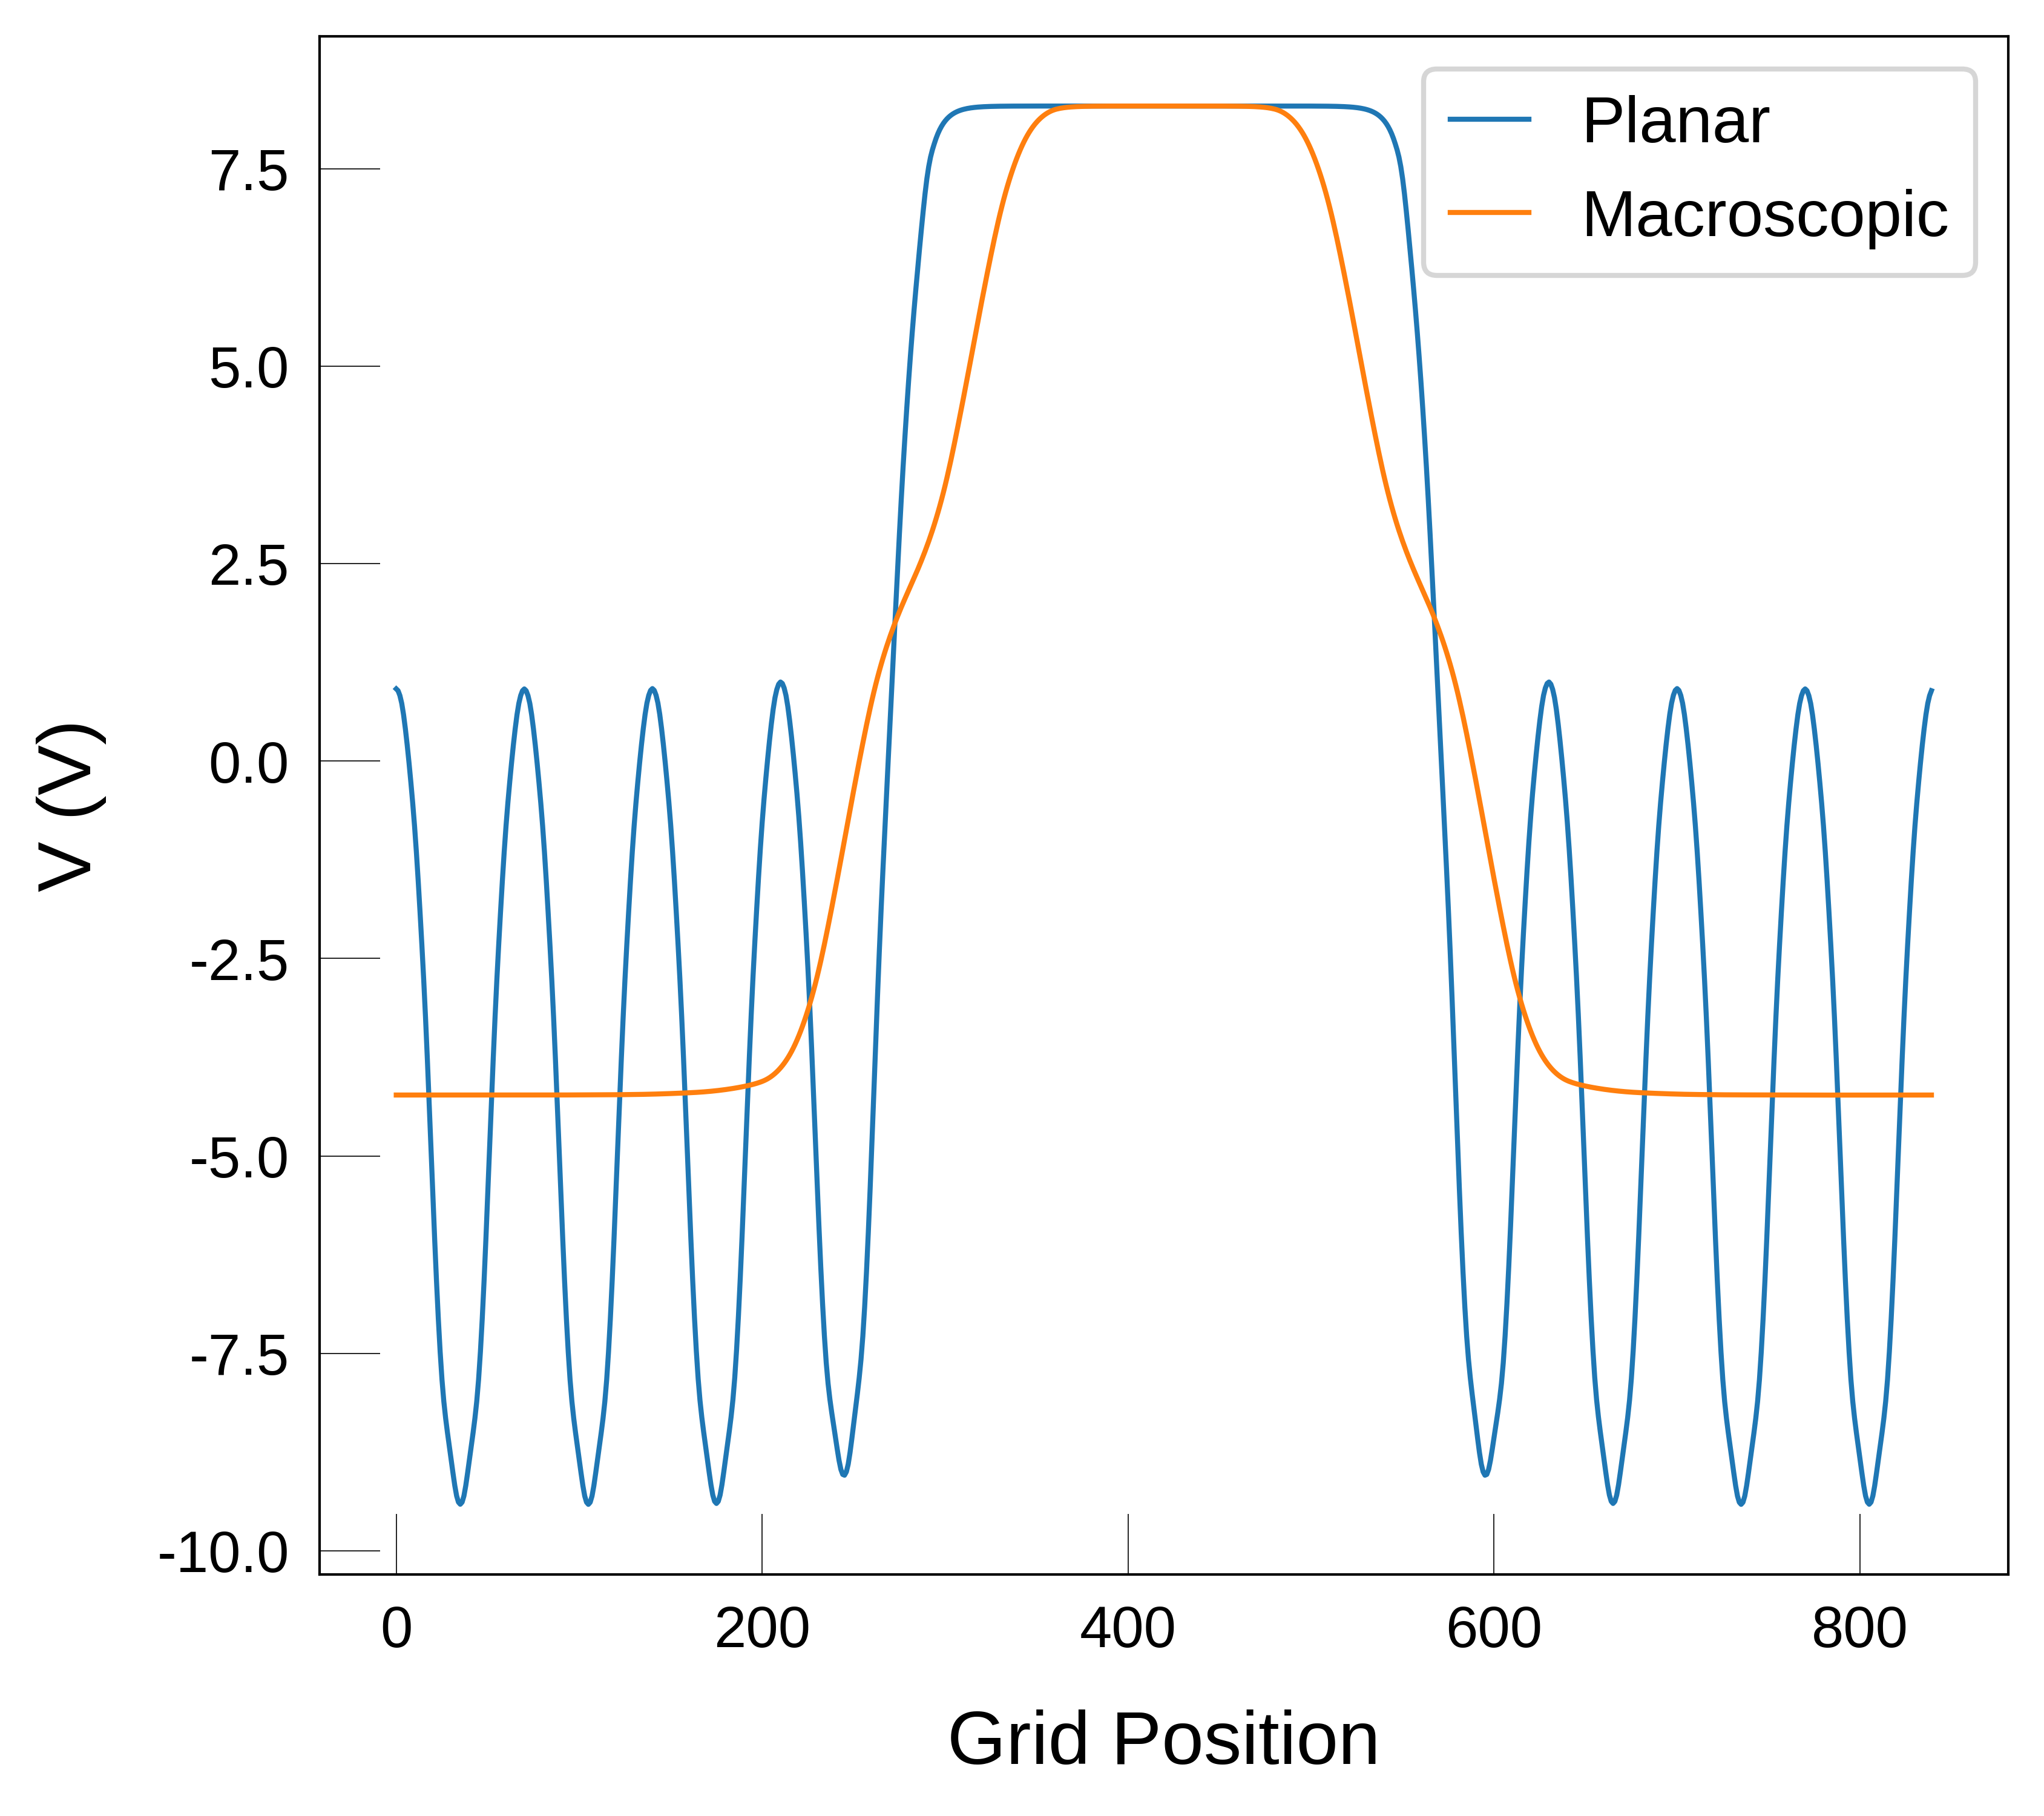

In [14]:
input_file = 'LOCPOT_Bi2O3.vasp'
# The lattice_vector is the size of the periodic/repeating unit of the slab in the direction normal to the surface.
# Typically, this is the c lattice vector of the bulk structure.
lattice_vector = lattice_vector_c
output_file = 'planar.dat'

# To perform average along the z-axis, we set axis='z'
df, fig = md.plot_planar_average(
    input_file=input_file,
    output_file=output_file,
    lattice_vector=lattice_vector,
    axis='z', # averaging over the direction normal to the surface
)

```{note}
In the plot above, we see that the macroscopic average still looks a bit wavey at the interface. This is sometimes caused by numerical effects and can be solved by reducing the size of the `lattice_vector`. If we set it to half of the bulk `c` parameter, we get a smoother profile, as shown below.
```

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -5.5331031601624006e-15
Average of the average =  -1.0285951984336688e-14


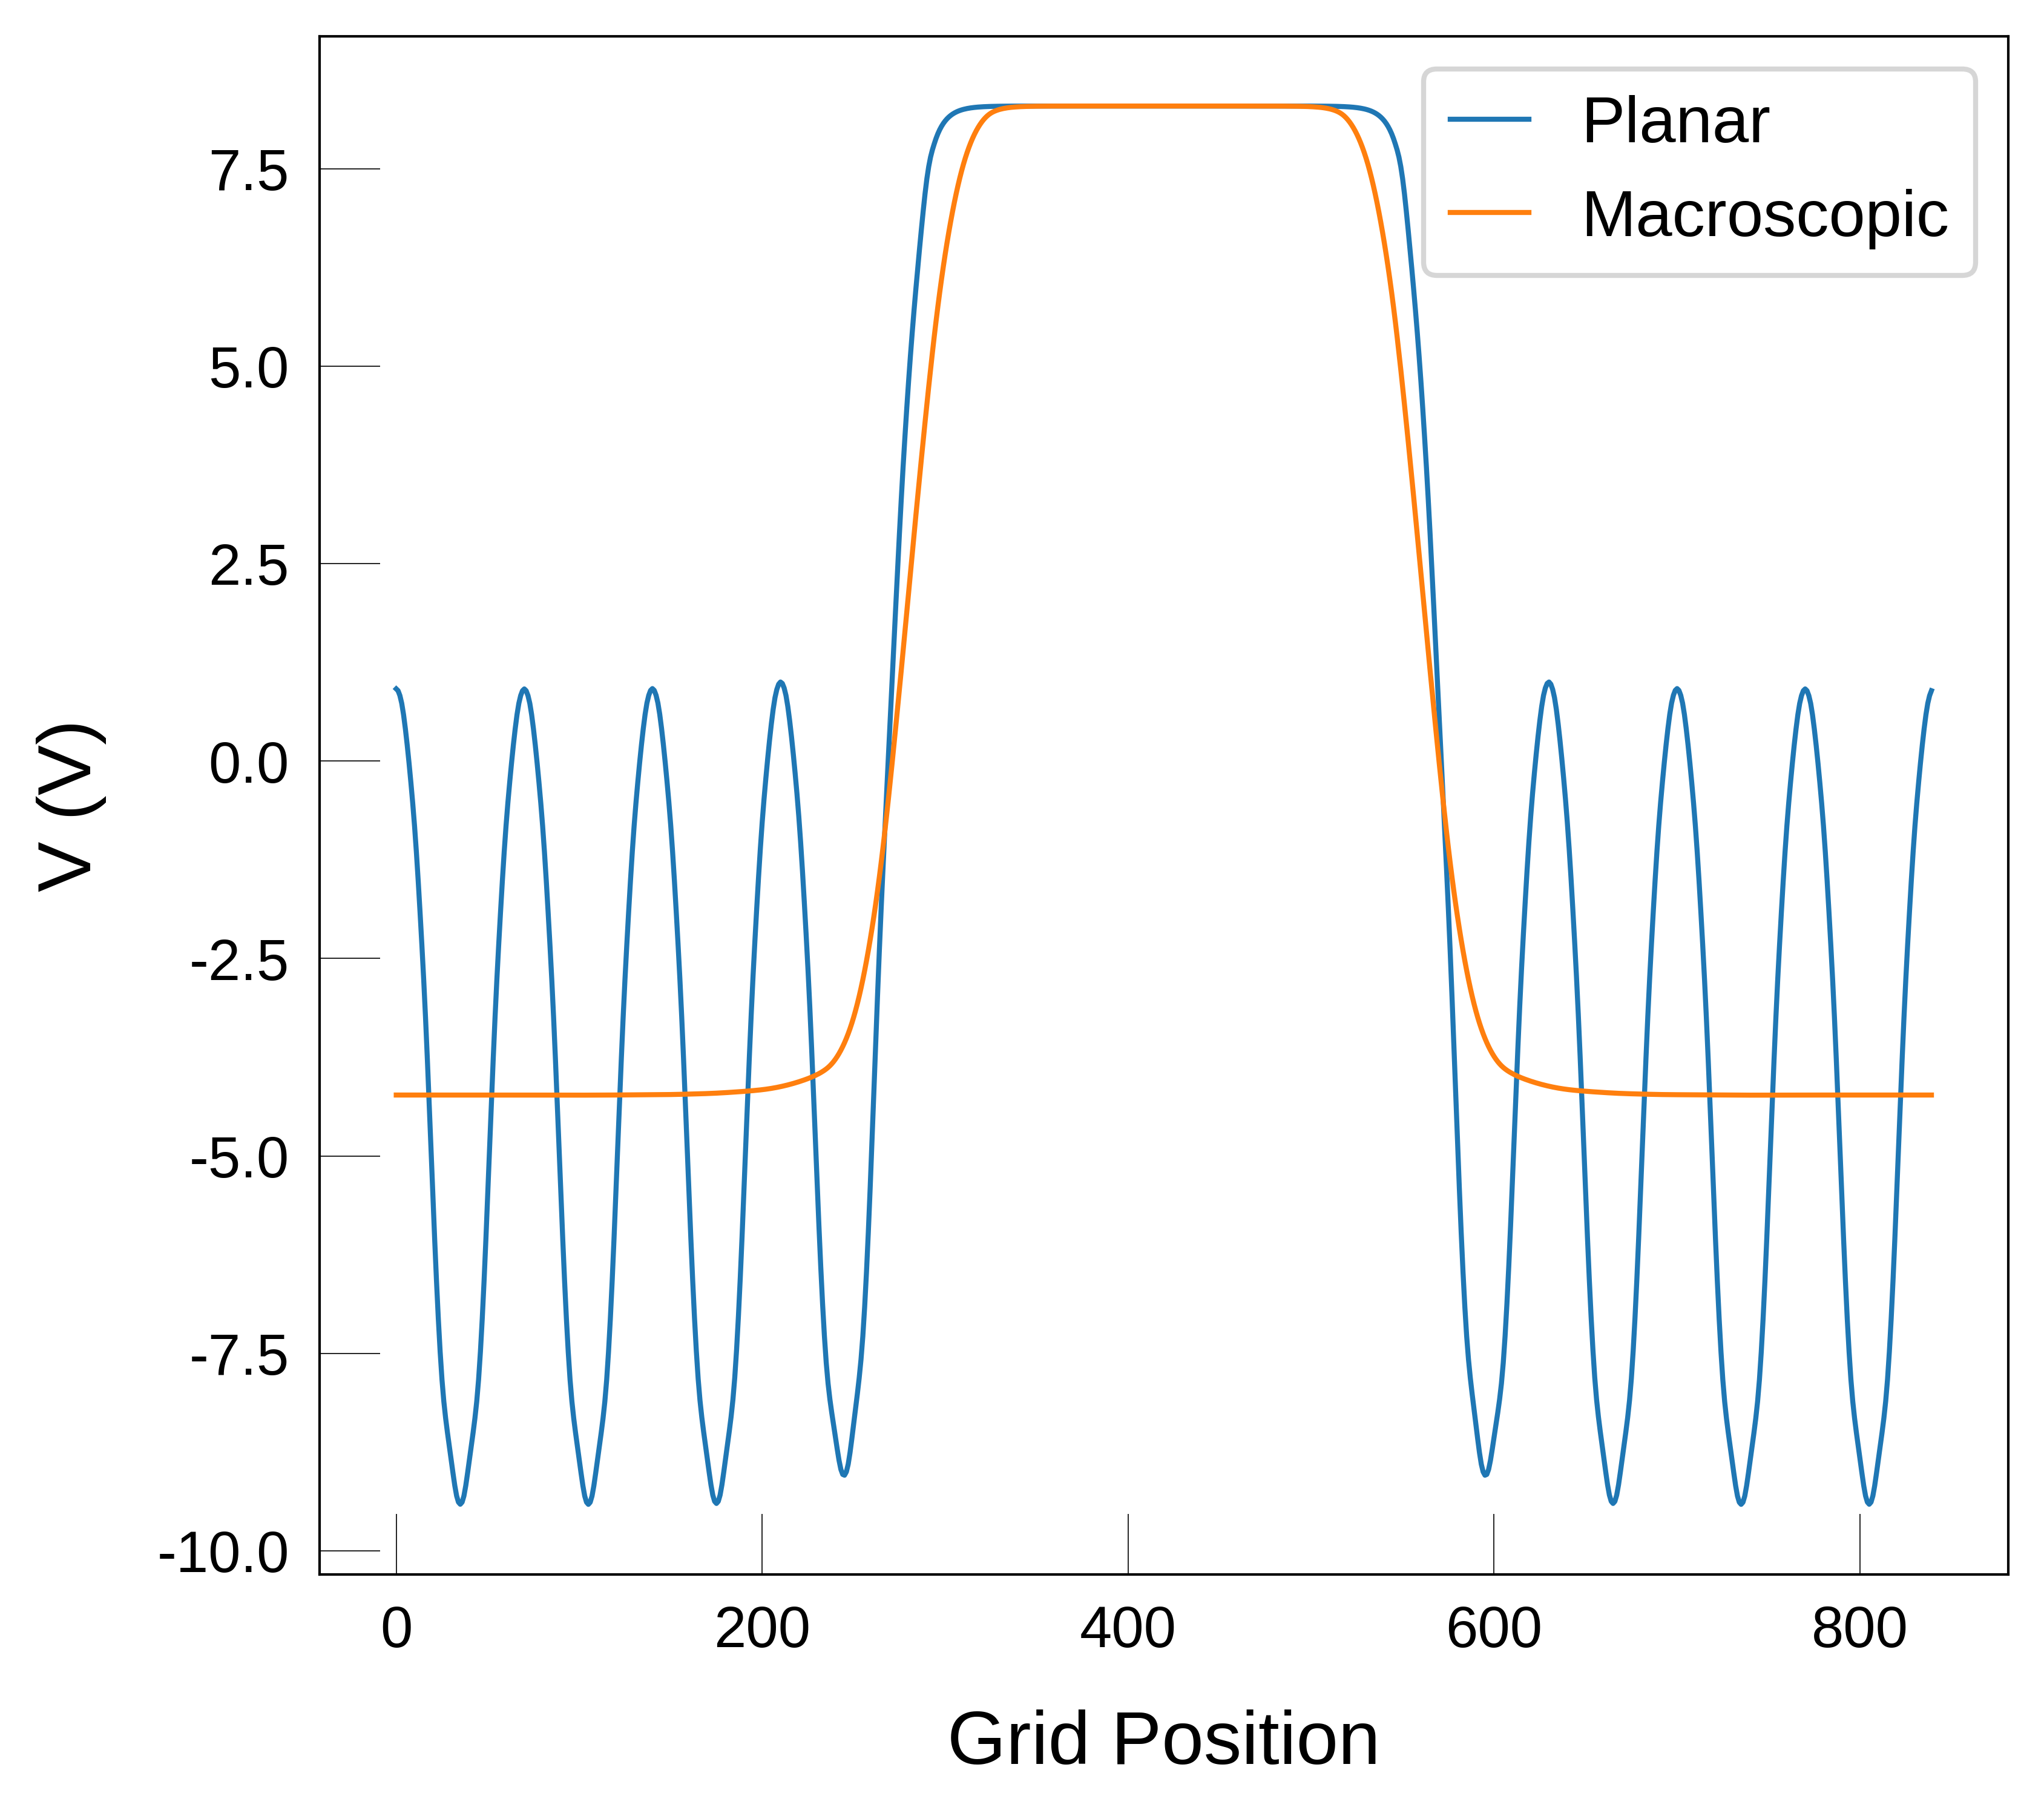

In [31]:
input_file = 'LOCPOT_Bi2O3.vasp'
# The lattice_vector is the size of the periodic/repeating unit of the slab in the direction normal to the surface.
# Typically, this is the c lattice vector of the bulk structure.
lattice_vector = lattice_vector_c / 2
output_file = 'planar.dat'

# To perform average along the z-axis, we set axis='z'
df, fig = md.plot_planar_average(
    input_file=input_file,
    output_file=output_file,
    lattice_vector=lattice_vector,
    axis='z', # averaging over the direction normal to the surface
)

### Get the surface dipole ($D_s$)

From looking at the macroscopic average in the plot above and the generated dataframe we find that the value of $V$ at each plateau is:

In [22]:
max_mac = df.Macroscopic.max()
min_mac = df.Macroscopic.min()

print("Values of V at the plateaus:", round(min_mac, 2), "V and", round(max_mac, 2), "V")

Values of V at the plateaus: -4.23 V and 8.29 V


So the step $D_s$ is 

In [23]:
D_s = max_mac - min_mac
print("D_s:", round(D_s, 2), "V")

D_s: 12.52 V


Applying the equation from earlier, the IP is 

In [26]:
ip = D_s - e_vbm
print(f"IP: {round(ip, 2)} eV")

IP: 6.7 eV
